In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdproc
#from convenience_functions import show_image

%matplotlib widget
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.close('all')

import warnings, pathlib, os
from astropy.utils.exceptions import AstropyWarning, AstropyUserWarning
#warnings.simplefilter('ignore', category=AstropyWarning)
#warnings.simplefilter('ignore', category=AstropyUserWarning)
#warnings.simplefilter('ignore', UserWarning)


In [3]:
import astropy.units as u
from astropy.io import fits
from astropy.nddata import StdDevUncertainty
from astropy.coordinates import get_sun, AltAz, EarthLocation, SpectralCoord, SkyCoord
from astropy.time import Time
from astropy.convolution import Box1DKernel
from astropy.modeling import models, fitting

from specreduce.tracing import FlatTrace, FitTrace
from specreduce.background import Background
from specreduce.extract import BoxcarExtract
from specreduce.fluxcal import FluxCalibration
from specreduce.wavelength_calibration import WavelengthCalibration1D
from specreduce.calibration_data import load_MAST_calspec, load_onedstds

from specutils import Spectrum
from specutils.manipulation import median_smooth, gaussian_smooth
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils.analysis import centroid, fwhm, snr, snr_derived
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

from importlib.metadata import version  
for module in ['matplotlib', 'numpy', 'astropy', 'specutils', 'specreduce', 'ccdproc', 'pandas']:
    try:
        print(f"{module} = {version(module)}")
    except Exception as e:
        print(f"{e}")



matplotlib = 3.10.0
numpy = 2.3.1
astropy = 7.0.1
specutils = 2.2.0
No package metadata was found for specreduce
ccdproc = 2.4.3
pandas = 2.2.3


In [4]:
# define frames locations
CAPTURE_DIR = '../../../CAPTURES/20250822_v1296Aql_altair_Tcrb_rsOph/'

OUTPUT_CALIB = 'master_calib.fits'
OUTPUT_SCIENCE = 'master_science.fits'
OUTPUT_RESPONSE = 'response_spec.fits'

# vérifie que ces fichiers existent bien
for _type in (OUTPUT_SCIENCE, OUTPUT_CALIB):
    print("\n",[f.name for f in pathlib.Path(CAPTURE_DIR).glob(_type)])

### Observatory location
# CALC
#OBS_LATITUDE = 47.89
#OBS_LONGITUDE = -1.50
#ALTITUDE: 50

#OHP
#OBS_LATITUDE = 43.931
#OBS_LONGITUDE = 5.712
#ALTITUDE: 600

#MEUSE
OBS_LONGITUDE = 5.622875
OBS_LATITUDE = 48.686385
ALTITUDE = 250

WAVE_RANGE = 3000, 9000
WAVELENGTH = [4500.9, 4671.2, 4916.5, 5400.5, 5852.5, 6143.0, 6382.9, 6598.9, 7032.4]*u.AA
PIXELS = [78.099, 128.005, 200.651, 339.185, 468.038, 550.164, 617.539, 677.917, 796.963]*u.pix
#WAVELENGTH = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA
#PIXELS = [770, 1190, 2240, 3484, 4160]*u.pix




 ['master_science.fits']

 ['master_calib.fits']


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                  c1                    c2          
    ----------------- --------------------- ----------------------
    607.8062896427318 -0.018201132609090294 1.4465310796274628e-05


/Users/papa/miniforge3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


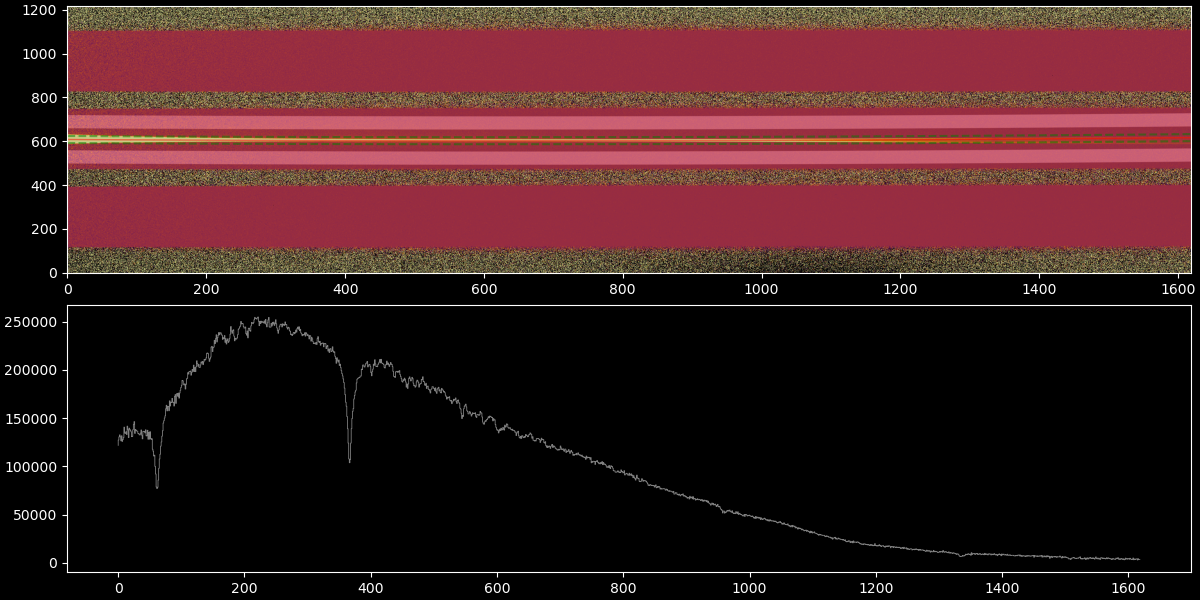

In [5]:
# charge le spectre 2D prétraité
master_science = CCDData.read(CAPTURE_DIR + OUTPUT_SCIENCE, unit=u.Unit('adu'))

# trace le spectre
science_trace = FitTrace(master_science,  
                          bins = 32, 
                          trace_model = models.Polynomial1D(degree=2),
                          peak_method = 'gaussian', 
                          window = 40,
                          #guess=615
                         ) 
#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian

# trace le fond de ciel
bg = Background.two_sided(master_science, 
                          science_trace, 
                          separation = 80, 
                          width = 60) 

# extrait le spectre
extract = BoxcarExtract(master_science - bg, 
                        science_trace, 
                        width = 16)

science_spectrum = extract()

# stats sur l'extraction
print(science_trace.trace_model_fit)

# affiche l'image brut avec les zones de fond de ciel
fig, axes = plt.subplots(2, figsize = (12, 6))
im = axes[0].imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.inferno)
axes[0].imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.2)
im.set_clim(np.percentile(master_science, (10, 90)))

# affiche le spectre extrait
axes[0].step(science_spectrum.spectral_axis, science_trace.trace , color='red', linewidth = '1.0', alpha=0.5)
axes[0].step(science_spectrum.spectral_axis, science_trace.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
axes[0].step(science_spectrum.spectral_axis, science_trace.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
axes[1].step(science_spectrum.spectral_axis , science_spectrum.flux, color='grey', linewidth = '0.6')


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

emission: 
 line_center line_type line_center_index
    pix                                
----------- --------- -----------------
      938.0  emission               938
      955.0  emission               955
      990.0  emission               990
     1063.0  emission              1063
     1076.0  emission              1076
     1102.0  emission              1102
     1114.0  emission              1114
     1144.0  emission              1144
     1172.0  emission              1172
     1210.0  emission              1210
     1237.0  emission              1237
     1248.0  emission              1248
     1306.0  emission              1306
     1321.0  emission              1321
     1358.0  emission              1358
     1402.0  emission              1402
     1424.0  emission              1424
     1542.0  emission              1542
     1599.0  emission        


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


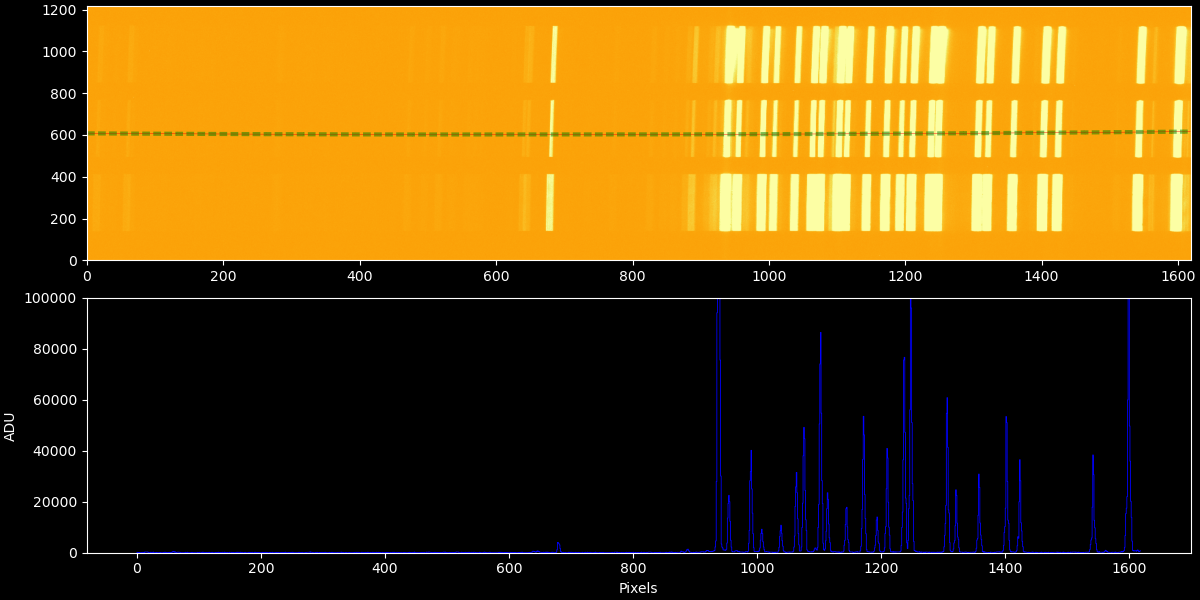

In [6]:
# charge le spectre 2D prétraité
master_calib = CCDData.read(CAPTURE_DIR + OUTPUT_CALIB, unit=u.Unit('adu'))

# extrait le spectre
extract = BoxcarExtract(master_calib, science_trace, width = 5)
neon_spectrum = extract()

#affiche le spectre
fig, axes = plt.subplots(2, figsize = (12, 6))
im = axes[0].imshow(master_calib, origin='lower', aspect='auto', cmap=plt.cm.inferno)
im.set_clim(np.percentile(master_science, (10, 85)))
axes[0].step(neon_spectrum.spectral_axis, science_trace.trace , color='red', linewidth = '0.3')
axes[0].step(neon_spectrum.spectral_axis, science_trace.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
axes[0].step(neon_spectrum.spectral_axis, science_trace.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)

axes[1].step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='blue', linewidth = '0.6')
axes[1].set_xlabel('Pixels')
axes[1].set_ylabel('ADU')
axes[1].set_ylim(0, 0.1e6)

### recherche les raies 
lines = find_lines_derivative(neon_spectrum, flux_threshold=15000)
print('\nemission: \n', lines[lines['line_type'] == 'emission']) 
print('\nabsorption: \n', lines[lines['line_type'] == 'absorption']) 

# readjust x-pixel positions accordingly
#PIXELS = [78.099, 128.005, 200.651, 339.185, 468.038, 550.164, 617.539, 677.917, 796.963]*u.pix

residuals : [ 0.49423012 -0.75870627  0.00778872  0.44850455 -0.19181713] Angstrom
fitted  Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                c1                  c2          
         Angstrom       Angstrom / pix     Angstrom / pix2    
    ----------------- ----------------- ----------------------
    4349.266439248307 1.703828342397139 3.2243160329371866e-05


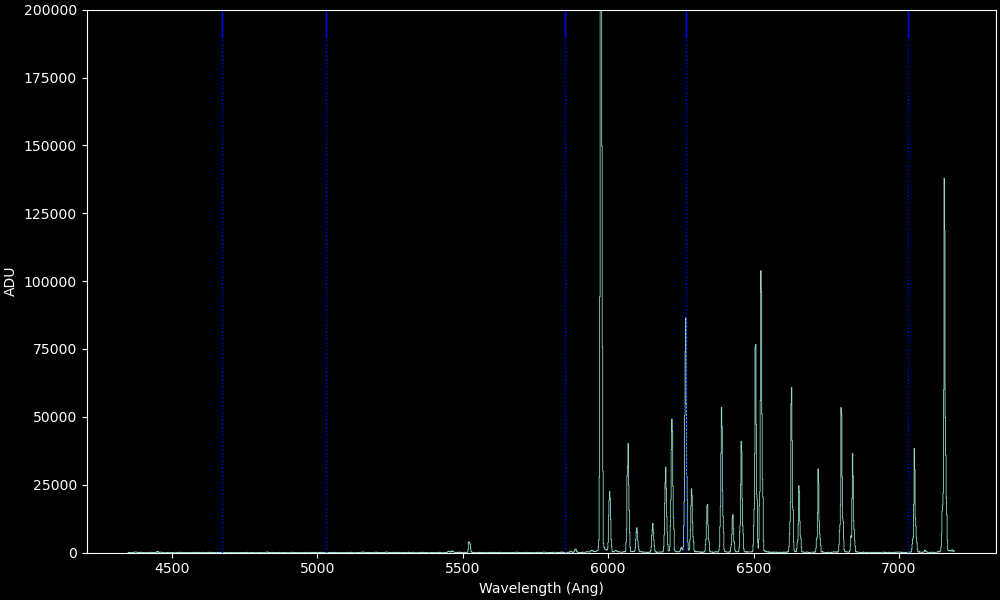

In [7]:
### alpy-600 + neon builtin
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
#pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
#wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
#wavelength_ = wavelength #= [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

# Dados200 + Xenon lamp
#pixels = [191, 400, 871, 1105, 1533]*u.pix
pixels = [188, 396, 868, 1102, 1530]*u.pix
wavelength = [4671.22, 5028.28, 5852.49, 6266.49, 7031.41]*u.AA

### Dados200 + neon lamp
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### StarEx-2400 + neon lamp
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#pixels = [853, 1266, 2314, 3599, 4238]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA
#wavelength = WAVELENGTH
#pixels = PIXELS

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
calibration = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 2),
      #fitter = fitting.LMLSQFitter()
      fitter = fitting.LinearLSQFitter()
     )
print('residuals :', calibration.residuals )
print('fitted ', calibration.fitted_model )

neon_calibrated_spectrum = calibration.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength:
    plt.axvline(line.value, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line.value, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);

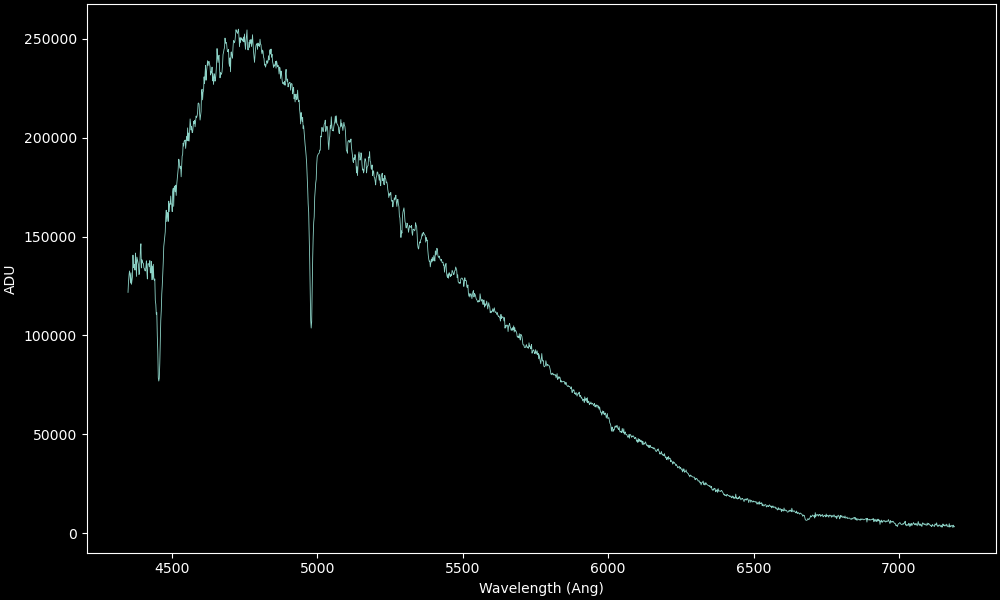

In [8]:

science_calibrated_spectrum = calibration.apply_to_spectrum(science_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.plot(science_calibrated_spectrum.wavelength, science_calibrated_spectrum.flux, linewidth = '0.6');

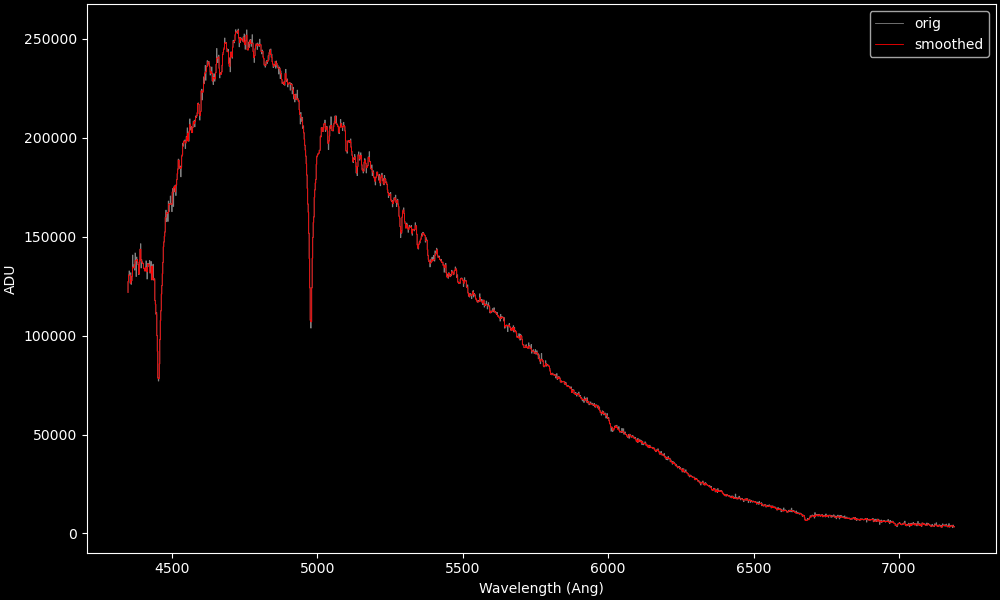

In [9]:
smooth_spec = median_smooth(science_calibrated_spectrum, width = 3) 

plt.figure(figsize=(10,6))
#plt.xlim(3000, 9000)
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.step(science_calibrated_spectrum.wavelength, science_calibrated_spectrum.flux + 100*u.adu, color = 'grey', linewidth = '0.6', label = 'orig')
plt.step(smooth_spec.wavelength, smooth_spec.flux , color = 'red', linewidth = '0.6', label = 'smoothed')
plt.legend(loc=('best'))

### decide to keep the median smoothed version ?
#science_calibrated_spectrum = smooth_spec


In [10]:
### compute zenith distance (if not present in fit header)
TARGET = master_science.meta['OBJECT']
target_coord = SkyCoord.from_name(TARGET)
target_time = Time(master_science.meta['DATE-OBS'])
obs_coord = EarthLocation(lon = OBS_LONGITUDE * u.deg, lat = OBS_LATITUDE * u.deg)
altaz = AltAz(obstime=target_time, location = obs_coord)

ZD = target_coord.transform_to(AltAz(obstime = target_time, location = obs_coord)).zen
airmass = 1.0 / np.cos(ZD)
print(f'computed ZD={ZD}, airmass={airmass}')

computed ZD=42.590146645718306 deg, airmass=1.3583016691222727


reusing existing response file ... 
response applied


Text(0, 0.5, 'ADU')

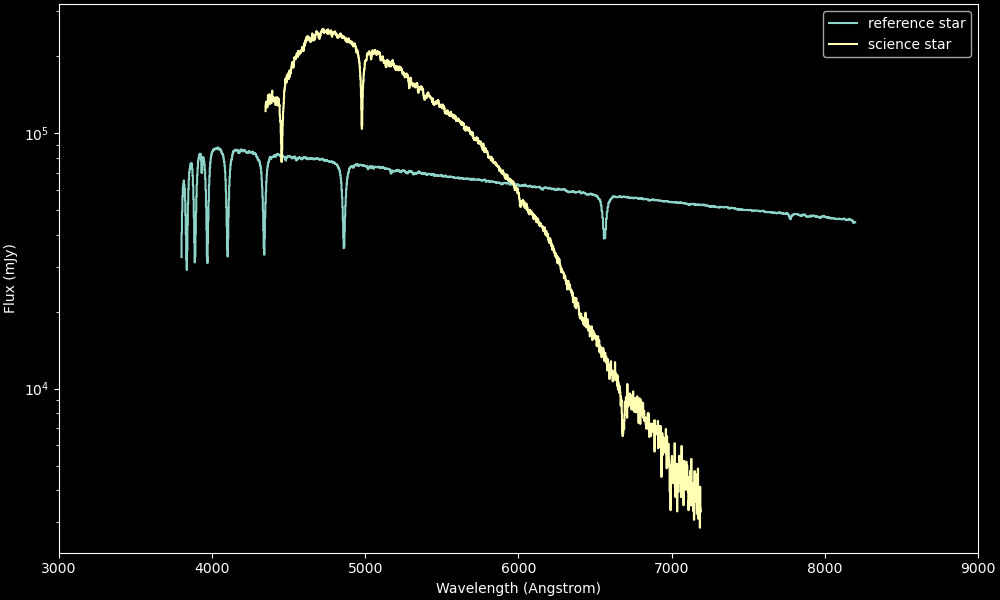

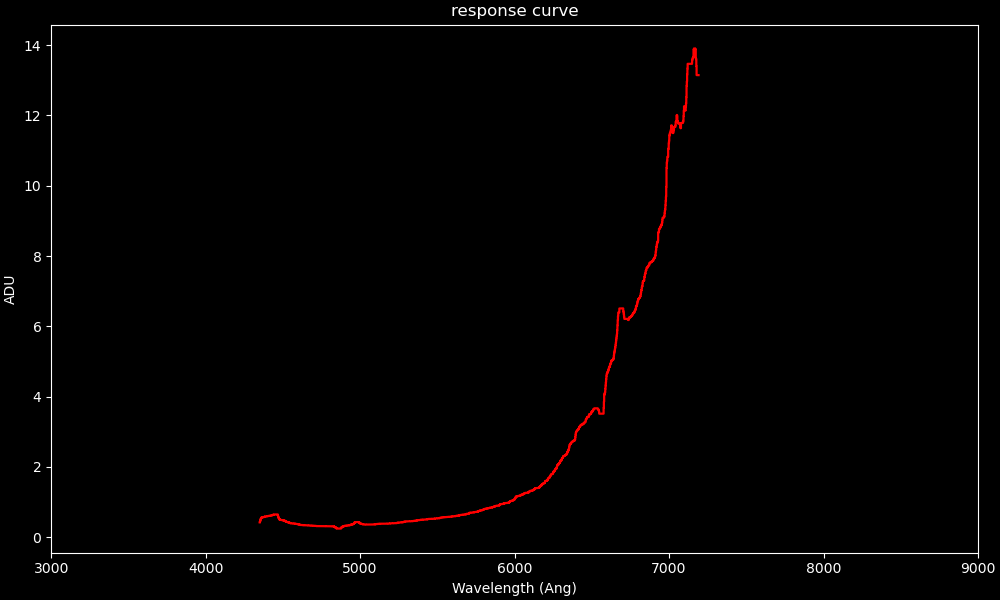

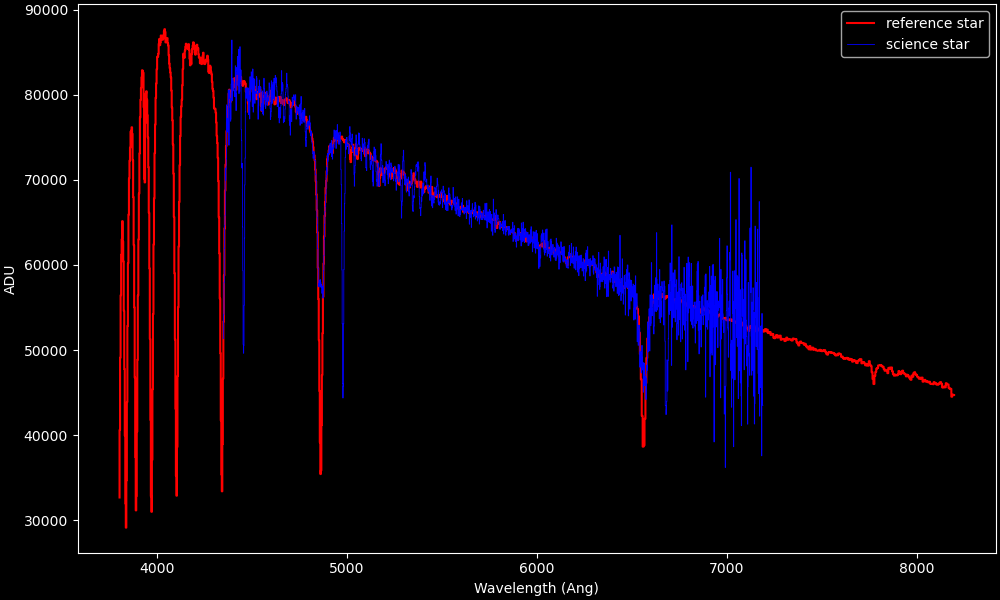

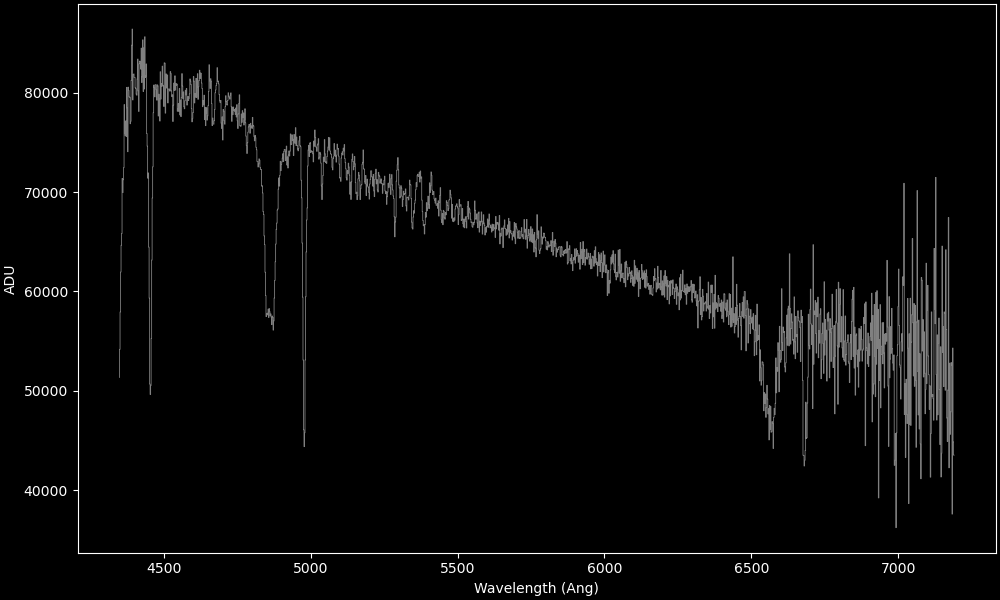

In [16]:
#std_spec = load_MAST_calspec("delumi_stis_004.fits")
#std_spec = load_MAST_calspec("bd60d1753_stiswfc_004.fits")
#std_spec = load_MAST_calspec("hd93521_stis_007.fits")         # O9Vp
#std_spec = load_MAST_calspec("hd101452_stis_004.fits")        # A2/3
#std_spec = load_MAST_calspec('etauma_stis_008.fits') # B3V

### load reference star from CALSPEC database
REFERENCE_STAR = 'delumi_stis_004.fits'
std_spec = load_MAST_calspec(REFERENCE_STAR)

### slice spectra to visible range
std_slice = std_spec[3800*u.AA:8200*u.AA]
sci_slice = science_calibrated_spectrum[3800*u.AA:8200*u.AA]
final_spec = sci_slice

### show both spectra
fig, ax = plt.subplots(figsize=(10,6))
plt.xlim(WAVE_RANGE)     
ax.step(std_slice.spectral_axis, std_slice.flux, label = 'reference star') #, where="mid"
ax.step(sci_slice.spectral_axis, sci_slice.flux, label = 'science star') # where="mid", 
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
plt.legend(loc=('best'))

obj_spectrum = sci_slice
std_spectrum = std_slice

fcal = FluxCalibration() 
fcal(airmass=airmass, object_spectrum=sci_slice)
                
### reuse response file if exists
#if False:
if os.path.exists(CAPTURE_DIR + OUTPUT_RESPONSE):
    print('reusing existing response file ... ')
    with fits.open(CAPTURE_DIR + OUTPUT_RESPONSE) as resp:
        specdata = resp[1].data
        header = resp[1].header
        responsefunc = Spectrum(flux = specdata['flux']* u.mJy, spectral_axis = specdata['wavelength'] * u.AA)
        
        final_spec = fcal.apply_sensfunc(responsefunc)
    print('response applied')
else:
    print('creating a new response file ...')
    responsefunc = fcal.standard_sensfunc(
        standard = std_spectrum,
        mode = 'linear', #'linear', # 'poly', #'spline', 
        polydeg = 7,
        #badlines=[7516, 6880, 6844, 6860, 6920, 6563, 6566, 4861, 4341],
        display = False)
    print('response created')

    ### filter the response func
    #smooth_response = gaussian_smooth(responsefunc, stddev=3) 
    smooth_response = median_smooth(responsefunc, width=31) #2055) 
    responsefunc = smooth_response
    print('response median smoothed')
        
    final_spec = fcal.apply_sensfunc(responsefunc)
    print('response applied')

    responsefunc.write(CAPTURE_DIR + OUTPUT_RESPONSE, overwrite = True)

#final_spec.write(CAPTURE_DIR + TARGET + '-1D.fit', overwrite = True)

plt.figure(figsize=(10,6))
plt.xlim(WAVE_RANGE)       # starEx2400

plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
plt.step(responsefunc.wavelength, responsefunc.flux, linewidth = '1.6', color = 'r');
plt.title('response curve')


plt.figure(figsize=(10,6))
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
#plt.step(obj_spectrum.wavelength, obj_spectrum.flux, linewidth = '0.6', color = 'black');
plt.step(std_slice.wavelength, std_slice.flux, color = 'r', label = 'reference star') #, where="mid", 
plt.step(final_spec.wavelength, final_spec.flux, linewidth = '0.6', color = 'b', label = 'science star'); #, where="mid",
plt.legend(loc=('best'))
#plt.step(std_spec.wavelength, std_spec.flux + 5000 * u.mJy, linewidth = '0.6', color = 'r')

plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='grey', linewidth = '0.6') #, where="mid")
plt.xlabel('Wavelength (Ang)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

#show_lines(ax = None, show_line = True)